# Parsa Madinei - 810098015 - Final Project

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_log_error
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from scipy.sparse import hstack
import copy
import hazm
import time

# Preprocessing & Previsualizations
first we find that the date which the row has created is weekend or not (friday and thursday)<br>
then we find the time within 24 hours, based on what we expect from the price if one letter has created on night or morning<br> after that, we clean brand to english brands, and then one-hot-encode

In [2]:
df = pd.read_csv('mobile_phone_dataset.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
# created_at
df['is_weekend'] = 'Nan'
df['time'] = 'Nan'
for i in range(len(df)):
    d = df['created_at'][i].split()[0]
    if ((d=='Friday')or(d=='Thursday')):
        df['is_weekend'][i] = 1
    else:
        df['is_weekend'][i] = 0

    t = df['created_at'][i].split()[1]
    am_pm = t[-2] + t[-1]
    hour = int(t[0] + t[1])
    if (am_pm=='AM'):
        df['time'][i] = hour
    else:
        df['time'][i] = hour+12

# beand
df['brand'] = [df['brand'][i].split('::')[0] for i in range(len(df))]

# get dummies
df = pd.get_dummies(df, columns=['city','brand'])

df.drop('created_at',axis=1,inplace=True)

/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [3]:
dd = df.copy()
# For keeping the main dataset

## Correlation Heatmap
As it has been clarified in the plot bellow, without description and title columns, the correlations of other columns with price is pretty low. most of correlations are between some of the brands like apple and cities like tehran.

<AxesSubplot:>

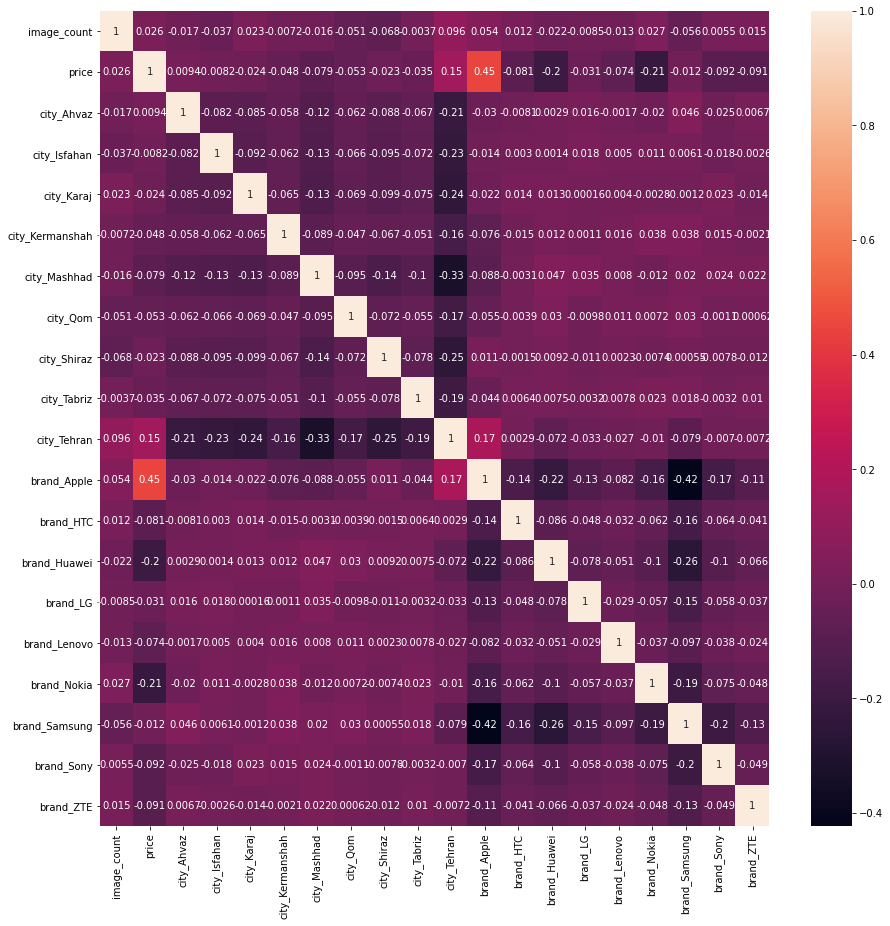

In [4]:
plt.figure(figsize=(15,15))
sns.heatmap(dd.corr(),annot=True)

## Text Preprocesses
As a result of that, lets preprocess the two desc and title columns. Lets start with normalizing (for better tokenizing) and tokenizing the column strings. by doing that, words will be separated from each other.

In [5]:
normalizer = hazm.Normalizer()
dd['title'] = [normalizer.normalize(df['title'][i]) for i in range(len(dd))]
dd['desc'] = [normalizer.normalize(df['desc'][i]) for i in range(len(dd))]

tokenizer = hazm.WordTokenizer()
dd['title'] = [tokenizer.tokenize(df['title'][i]) for i in range(len(dd))]
dd['desc'] = [tokenizer.tokenize(df['desc'][i]) for i in range(len(dd))]

Now let us normalize the words with the module "informal normalizer" for informal words. After that, the words may concatinate again with each othe. So we tokenize them again.

In [6]:
normalizer_inf = hazm.InformalNormalizer()
for i in range(len(dd)):
    temp = []
    for j in dd['desc'][i]:
        temp.append(normalizer_inf.normalized_word(j)[0])
    dd['desc'][i] = copy.deepcopy(temp)
    
    temp = []
    for j in dd['title'][i]:
        temp.append(normalizer_inf.normalized_word(j)[0])
    dd['title'][i] = copy.deepcopy(temp)

    
dd['title'] = [tokenizer.tokenize(df['title'][i]) for i in range(len(dd))]
dd['desc'] = [tokenizer.tokenize(df['desc'][i]) for i in range(len(dd))]

/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Personally, I guess finding word stems will reduce the precision of our model. as a result of that, I made 2 data frames; one with stemming (dd2) and one without it(dd). Also I removed '\u200c' from both.

In [7]:
dd2 = dd.copy()

In [8]:
stemmer = hazm.Stemmer()
for i in range(len(dd2)):
    temp = []
    temp2 = []
    for j in dd2['desc'][i]:
        temp = j.split('\u200c')
        for q in temp:
            temp2.append(stemmer.stem(q))
    dd2['desc'][i] = copy.deepcopy(temp2)

for i in range(len(dd2)):
    temp = []
    temp2 = []
    for j in dd2['title'][i]:
        temp = j.split('\u200c')
        for q in temp:
            temp2.append(stemmer.stem(q))
    dd2['title'][i] = copy.deepcopy(temp2)
    
for i in range(len(dd)):
    temp = []
    temp2 = []
    for j in dd['desc'][i]:
        temp = j.split('\u200c')
        for q in temp:
            temp2.append(q)
    dd['desc'][i] = copy.deepcopy(temp2)

for i in range(len(dd)):
    temp = []
    temp2 = []
    for j in dd['title'][i]:
        temp = j.split('\u200c')
        for q in temp:
            temp2.append(q)
    dd['title'][i] = copy.deepcopy(temp2)

/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/parsa

## Remove stopwords and Special Chars
Because they are useless to the meaning of sentences and as a result, to prices.

In [9]:
special_chars = ['!','"','#','(',')','*',',','-','.','/','\'','«','»','،','؛','؟','.','…','$']
stopwords = hazm.stopwords_list()
for i in range(len(dd2)):
    for j in dd2['desc'][i]:
        if (j in special_chars)or(j in stopwords):
            while (j in dd2['desc'][i]):
                dd2['desc'][i].remove(j)
                
    for j in dd2['title'][i]:
        if (j in special_chars)or(j in stopwords):
            while (j in dd2['desc'][i]):
                dd2['desc'][i].remove(j)
                
for i in range(len(dd)):
    for j in dd['desc'][i]:
        if (j in special_chars)or(j in stopwords):
            while (j in dd['desc'][i]):
                dd['desc'][i].remove(j)
                
    for j in dd['title'][i]:
        if (j in special_chars)or(j in stopwords):
            while (j in dd['desc'][i]):
                dd['desc'][i].remove(j)

## Just one word columns!
Because only words and the count of them will be important for us, I merged Two "title" and "desc" columns into one column and remove the othe two. Also I filled empty new columns with "missing" for further conciderations.

In [10]:
dd['titile_desc'] = dd['desc'] + dd['title']
dd.drop('title',axis=1,inplace=True)
dd.drop('desc',axis=1,inplace=True)

dd2['titile_desc'] = dd2['desc'] + dd2['title']
dd2.drop('title',axis=1,inplace=True)
dd2.drop('desc',axis=1,inplace=True)

dd['titile_desc'].fillna(value='Missing',inplace=True)
dd2['titile_desc'].fillna(value='Missing',inplace=True)

## Column Normalizations
purpose of normalization : scale numeric data from different columns down to an equivalent scale so that the model doesn’t get skewed due to huge variance in a few columns. for example, prices are vary through dataframe and distances between them are very high. As a result, I splited test columns(unknown prices) and then I used standard scaler normalizer.

After normalization, the RMSE has increased; reason being prices are large numbers and the regression models just try to calculate given numbers to predict the prices. As a result, low numbers could not lead us to the specific large numbers, so that I commented out normalization section.

In [53]:
main1 = dd.loc[dd['price']!=-1]
main2 = dd2.loc[dd['price']!=-1]

test1 = dd.loc[dd['price']==-1]
test2 = dd2.loc[dd['price']==-1]

# temp = list(main1.columns)
# temp.remove('price')
# temp.remove('titile_desc')
# ss = StandardScaler()

# main1[temp] = ss.fit_transform(main1.drop(['price','titile_desc'],axis=1))
# main2[temp] = ss.fit_transform(main2.drop(['price','titile_desc'],axis=1))
# test1[temp] = ss.fit_transform(test1.drop(['price','titile_desc'],axis=1))
# test2[temp] = ss.fit_transform(test2.drop(['price','titile_desc'],axis=1))

## Title-Description Feature Extraction : TF-IDF vectorizer
A machine understands only numbers, it does not directly understand letters or text that we as humans can read. That means we need to convert our text and categorical data to numbers. This process is called feature extraction or featurization.

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. In other words, that is intended to reflect how important a word is to a document in a collection or corpus. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents. n-gram is a contiguous sequence of n items from a given sample of text or speech. The items here are just words!

I first used sklean's built-in TfidfVectorizer and I have encoded name and item_descriptions into TF-IDF vectors of uni-grams, bi-grams and tri-grams because I guess will be the most important features. I also limited the number of features to 1M in the pursuit of avoiding very high dimensional vectors.

But before doing that, splited words in merged title+description column should be convert to sentences.

In [54]:
for i in list(main1.index):
    main1['titile_desc'][i] = ' '.join(main1['titile_desc'][i])
    
for i in list(main1.index):
    main2['titile_desc'][i] = ' '.join(main2['titile_desc'][i])

/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [56]:
vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=1, max_features=1000000)
tfidf_dd = vectorizer.fit_transform(main1['titile_desc']) 
tfidf_dd2 = vectorizer.fit_transform(main2['titile_desc']) 

In [57]:
dictvectorizer = DictVectorizer()
dd_make_dict = main1.drop(['price','titile_desc'],axis=1).to_dict('records')
categorised_dd = dictvectorizer.fit_transform(dd_make_dict)
X_dd = hstack([tfidf_dd,categorised_dd])

dd2_make_dict = main2.drop(['price','titile_desc'],axis=1).to_dict('records')
categorised_dd2 = dictvectorizer.fit_transform(dd2_make_dict)
X_dd2 = hstack([tfidf_dd2,categorised_dd2])

# Train-Validation Split

In [58]:
seed = 101
X_train1, X_test1, y_train1, y_test1= train_test_split(X_dd, main1['price'], test_size=0.2, random_state=seed)
X_train2, X_test2, y_train2, y_test2= train_test_split(X_dd2, main2['price'], test_size=0.2, random_state=seed)

# Reports
Here is the function that reports each model mean squared error, Root mean Squared error, and and its R2 score. It also generates random predictions in order to allow us to compare model scores to a random model.

In [59]:
def makeRandom(y_test):
    rands = []
    for counter in range(len(y_test)):
        rands.append(np.random.choice(list(range(1,300))))
    return rands

def reportRegressor(model,X_cross,y_cross,X_test,y_test):
    validationSetMSE = metrics.mean_squared_error(y_cross,model.predict(X_cross))
    validationSetR2 = metrics.r2_score(y_cross,model.predict(X_cross))
    validationSetRMSE = np.sqrt(validationSetMSE)
    testSetMSE = metrics.mean_squared_error(y_test,model.predict(X_test))
    testSetR2 = metrics.r2_score(y_test,model.predict(X_test))
    testSetRMSE = np.sqrt(testSetMSE)
    random_predicts = makeRandom(y_test)
    randomMSE = metrics.mean_squared_error(y_test,random_predicts)
    randomR2 = metrics.r2_score(y_test,random_predicts)
    randomRMSE = np.sqrt(randomMSE)
    print('Validation-set:\n\tMean Squared Error: ' , validationSetMSE ,'\n\tRoot Mean Squared Error: ',validationSetRMSE, '\n\tR2 Score: ' , validationSetR2)
    print('\nTest-set:\n\tMean Squared Error: ' , testSetMSE ,'\n\tRoot Mean Squared Error: ',testSetRMSE, '\n\tR2 Score: ' , testSetR2)
    print('\nRandom Predicts on Test-set:\n\tMean Squared Error: ' , randomMSE ,'\n\tRoot Mean Squared Error: ',randomRMSE, '\n\tR2 Score: ' , randomR2)

# Models & Evaluations
Some the models have been grid searched (with the commented code at the end of this part)...But because I didn't have the time, I just applied for some of them with best params_!

As models below indicate, in most of them, with stemming(train-test2) and without it (train-test1) doesn't make any differences as much, although without stemming the model is Slightly better.

Also we should note that high values of MSE and RMSE is because of great number of prices; for instance, if the model predicts the all prices with 20 Thousand Tomans, It performs pretty well, although MSE will be high. We should rely more on R2 score, which we know what it is from the class!

Fitting times was very high, So I was just able to make limited models.

## Linear Regression

In [77]:
from sklearn.linear_model import LinearRegression
linear_regressor = LinearRegression()
linear_regressor.fit(X_train1,y_train1)
reportRegressor(linear_regressor,X_train1,y_train1,X_test1,y_test1)

Validation-set:
	Mean Squared Error:  1810939.2045057411 
	Root Mean Squared Error:  1345.7114120441058 
	R2 Score:  0.9999940423161885

Test-set:
	Mean Squared Error:  88252983209.11693 
	Root Mean Squared Error:  297074.0365786228 
	R2 Score:  0.7055268856244272

Random Predicts on Test-set:
	Mean Squared Error:  775084484667.6342 
	Root Mean Squared Error:  880388.8258421015 
	R2 Score:  -1.5862190013842583


It is completely overfitted! hyperparameters need to be changed.

## Decision Tree:


In [70]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(max_depth=7)
dtr.fit(X_train2, y_train2) 
reportRegressor(dtr,X_train2,y_train2,X_test2,y_test2)

Validation-set:
	Mean Squared Error:  133076818020.74733 
	Root Mean Squared Error:  364796.95451133815 
	R2 Score:  0.5621997677010022

Test-set:
	Mean Squared Error:  142836858112.32013 
	Root Mean Squared Error:  377937.6378614865 
	R2 Score:  0.5233972504216543

Random Predicts on Test-set:
	Mean Squared Error:  775085621768.9314 
	Root Mean Squared Error:  880389.4716368043 
	R2 Score:  -1.5862227955422368


In [71]:
dtr.fit(X_train1, y_train1) 
reportRegressor(dtr,X_train1,y_train1,X_test1,y_test1)

Validation-set:
	Mean Squared Error:  131512236636.03993 
	Root Mean Squared Error:  362646.15899805137 
	R2 Score:  0.5673469759365402

Test-set:
	Mean Squared Error:  140832177038.79617 
	Root Mean Squared Error:  375276.13438479695 
	R2 Score:  0.5300862557967088

Random Predicts on Test-set:
	Mean Squared Error:  775082509490.4631 
	Root Mean Squared Error:  880387.7040772793 
	R2 Score:  -1.5862124108243494


Not very accurate...right?! But no overfitting.

## Ridge
alpha changed to where test-set had the best scores.

Also we should note that Ridge Regression is a technique for analyzing multiple regression data that suffer from multicollinearity; thats why it performs a great model!

In [75]:
from sklearn.linear_model import Ridge
ridge1 = Ridge(alpha=0.8, random_state=seed, solver='auto')
ridge1.fit(X_train1, y_train1) 
reportRegressor(ridge1,X_train1,y_train1,X_test1,y_test1)

Validation-set:
	Mean Squared Error:  21548831738.122257 
	Root Mean Squared Error:  146795.20338935553 
	R2 Score:  0.9291079867926274

Test-set:
	Mean Squared Error:  86184620392.58644 
	Root Mean Squared Error:  293572.1723743353 
	R2 Score:  0.7124283774278164

Random Predicts on Test-set:
	Mean Squared Error:  775085153598.1973 
	Root Mean Squared Error:  880389.2057483424 
	R2 Score:  -1.586221233400209


In [67]:
ridge2 = Ridge(alpha=0.8, random_state=seed, solver='auto')
ridge2.fit(X_train2, y_train2) 
reportRegressor(ridge2,X_train2,y_train2,X_test2,y_test2)

Validation-set:
	Mean Squared Error:  21739253603.93561 
	Root Mean Squared Error:  147442.3738412252 
	R2 Score:  0.928481531048285

Test-set:
	Mean Squared Error:  87251557907.96828 
	Root Mean Squared Error:  295383.7468581646 
	R2 Score:  0.7088683344516582

Random Predicts on Test-set:
	Mean Squared Error:  775084096122.4907 
	Root Mean Squared Error:  880388.6051752889 
	R2 Score:  -1.586217704928384


## Support Vector Regressor
Not very good. Hyperparameters need to be grid-seached!

In [ ]:
from sklearn.svm import SVR
svr = SVR(C = 100 , epsilon=0.2,gamma=1,kernel='rbf')
svr.fit(X_train1,y_train1)
reportRegressor(svr,X_train1,y_train1,X_test1,y_test1)

As the ridge was the best model, I used it to predict unknown prices. Also, I just used without stemming description preprocess. Below is the code for preparing test set for being predicted by ridge.

In [73]:
# for i in list(test1.index):
#     test1['titile_desc'][i] = ' '.join(test1['titile_desc'][i])
    
# vectorizer = TfidfVectorizer(ngram_range=(1, 3), min_df=1, max_features=1000000)
# tfidf_dd = vectorizer.fit_transform(test1['titile_desc']) 

# dd_make_dict = test1.drop(['price','titile_desc'],axis=1).to_dict('records')
# categorised_dd = dictvectorizer.fit_transform(dd_make_dict)
# X_dd = hstack([tfidf_dd,categorised_dd])

/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/parsa/.pyenv/versions/3.7.3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Bellow is the code I used for grid-searching in the pursuit of finding best parameters for some of the models mentioned above.

In [ ]:
# model = X!
# params = {'':['','',''] , '':[ , , , ]}
# gs = GridSearchCV(estimator=model, param_grid=params, scoring='mean_squared_error', n_jobs=1, cv=5, verbose=3)
# start = time.time()
# gs.fit(X_train1, y_train1)
# end = time.time()
# print('Time to train model: %0.2fs' % (end -start))

# model = gs.best_estimator_
# print(gs.best_params_)
# print(gs.best_score_)

# Other Ideas:
1- Visualizing more at the beggining could lead us to better preprocesses and algorithm selections.

2- Other regression algorithms could be easily done by the sklearn; and we could evaluate them using the repportRegressor function! Algorithms such as Logistic Regression, Polynomial Regression, Stepwise Regression, Lasso Regression, ElasticNet Regression, and of course neural nets. Also I guess voting models based on grid searched mention Algorithms could do a great job!

3- I didn't have the time to grid-search for some of the Algorithms and ofcourse more parameters. I applied, But we would have much better models with that.